In [118]:
import os
import time

import numpy as np
from tqdm import tqdm
from fidelity_simulation import FidelitySimulation
from pulse import RectangularReadoutPulse
from floquet_analysis.transmon_resonator_fitter import TransmonResonatorFitter
import matplotlib.pyplot as plt

from fidelity_analysis.utils import setup_plotting
from fidelity_analysis.pulse import Pulse
from fidelity_analysis.utils import S2pUtils

setup_plotting(dpi=50)

In [119]:
# Measured frequencies GHz
f01_meas = 3.845965050
f12_meas = 3.602264855
alpha = f12_meas - f01_meas

fr0_meas = 6.065852884
fr1_meas = 6.064931745
fr2_meas = 6.064094073

kappa_div2pi = 0.55e-3

fitter = TransmonResonatorFitter(f01_meas, f12_meas, fr0_meas, fr1_meas, fr2_meas)

EJ_fitted, EC_fitted, fr_fitted, g_fitted = fitter.fit_parameters()

fitter.print_results()

Initial guess for [EJ, EC, fr, g]: [8.578861527050124, 0.24370019500000017, 6.0653923145, np.float64(0.09103399089132334)]

--- Fitting Results ---
Fitted EJ: 9.8266 GHz
Fitted EC: 0.2106 GHz
Fitted Resonator Freq (bare, f_r): 6.0650 GHz
Fitted Coupling Strength (g): 0.1017 GHz

Fitted Frequencies (from model with fitted parameters):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0650 GHz
  Resonator freq @ Qubit |1>: 6.0650 GHz
  Resonator freq @ Qubit |2>: 6.0650 GHz

Measured Frequencies (input data):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0659 GHz
  Resonator freq @ Qubit |1>: 6.0649 GHz
  Resonator freq @ Qubit |2>: 6.0641 GHz

Total Squared Error: 1.55e-06


In [120]:
#TEMPLATE_FILE = "template_0ghz_resonator_cut_wide.s2p"
# TEMPLATE_FILE = "data_00000_0_ghz.s2p"
#
current_path = os.path.abspath("")
# data_dir_path = os.path.join(current_path, "data")
# template_file_path = os.path.join(data_dir_path, TEMPLATE_FILE)
#
# simulation_path = os.path.join(data_dir_path, time.strftime("%Y%m%d-%H%M%S"))


In [121]:
# current_path = os.path.abspath("")
# data_dir_path = os.path.join(current_path, "data")

In [122]:
# f_pulse = fr0_meas * 10 ** 9  # Hz
#
pulse_length = 2 * 10 ** (-6)  # s
#
pulse_samples_number = 2 ** 19
#
# rect_readout_pulse = RectangularReadoutPulse(
#     carrier_frequency=f_pulse,
#     pulse_duration=pulse_length,
#     pulse_power_dbm=-110,
#     total_signal_time=2 * pulse_length,
#     pulse_samples_number=pulse_samples_number,
# )
#
# rect_readout_pulse.plot_pulse()

In [123]:
fr_0 = (fr0_meas + fr1_meas) / 2
fr_arr = fr_0 + np.linspace(-2, 4, 50)
delta_arr_ghz = (f01_meas - fr_arr)
delta_arr = (f01_meas - fr_arr) * 1e9

In [124]:
def chi(delta_val):
    return g_fitted ** 2 / delta_val * (1 / (1 + delta_val / alpha))

# def chi(delta_val):
#     return g_fitted ** 2 / delta_val

In [125]:
def plot_states(state_0_for_plot, state_1_for_plot, pulse):
    plt.plot(state_0_for_plot.f, state_0.s[:, 1, 0])
    plt.plot(state_1_for_plot.f, state_1.s[:, 1, 0])

    plt.plot(
        pulse.f_signal_frequencies,
        5e11 * np.abs(pulse.f_signal),
        c='black',
        label="Scaled Rect Readout pulse",
        linewidth=3
    )

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (a.u.)')
    plt.xlim(pulse.carrier_frequency - 5e6, pulse.carrier_frequency + 5e6)
    plt.legend(loc='lower left')
    plt.show()


In [134]:
# f01_meas - if TEMPLATE_FILE = "template_0ghz_resonator_cut_wide.s2p"
# 0 - if TEMPLATE_FILE = "data_00000_0_ghz.s2p"
# original_peak_frequency = 0

# shift_s2p_freq_axis_minimal(template_file_path, os.path.join(simulation_path, "original.s2p"), original_peak_frequency)

fidelity = []

Q = fr_0 / kappa_div2pi

for fr in (pbar := tqdm(fr_arr)):
    # file_state_0 = os.path.join(simulation_path, f"{delta}_0.s2p")
    # file_state_1 = os.path.join(simulation_path, f"{delta}_1.s2p")
    # shift_s2p_freq_axis_minimal(template_file_path, file_state_0, original_peak_frequency + chi(delta))
    # shift_s2p_freq_axis_minimal(template_file_path, file_state_1, original_peak_frequency - chi(delta))
    delta = f01_meas - fr

    state_0 = S2pUtils.create_resonator_S21((fr + chi(delta)) * 1e9, Q, Q)
    state_1 = S2pUtils.create_resonator_S21((fr - chi(delta)) * 1e9, Q, Q)

    pulse = RectangularReadoutPulse(
        carrier_frequency=fr * 1e9,
        pulse_duration=pulse_length,
        pulse_power_dbm=-123,
        total_signal_time=3 * pulse_length,
        pulse_samples_number=pulse_samples_number,
    )
    # plot_states(state_0, state_1, pulse)

    fidelity_simulation = FidelitySimulation(
        s_parameters_file_state_0=state_0,
        s_parameters_file_state_1=state_1,
        readout_pulse=pulse,
        IQ_projection_frequency=(6.2 - fr_0 + fr) * 1e9,
        num_iterations=250,
        readout_dt=1e-9,
        plot_pulses=False,
        plot_result=False,
        disable_progress_bar=True,
    )
    # pulse.plot_pulse()

    result = fidelity_simulation.run()
    fidelity.append(result)
    pbar.set_postfix_str(f"fidelity = {result}, delta = {delta}")



100%|██████████| 50/50 [02:23<00:00,  2.87s/it, fidelity = 0.92, delta = -6.2194272645]       


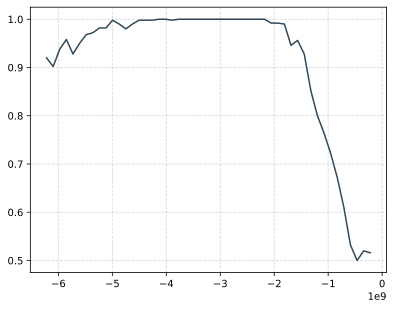

In [135]:
plt.plot(delta_arr, fidelity)

  0%|          | 0/50 [00:00<?, ?it/s]InvalidFrequencyWarning: Frequency values are not monotonously increasing!
To get rid of the invalid values call `drop_non_monotonic_increasing`
100%|██████████| 50/50 [00:00<00:00, 658.55it/s]/python3.12/site-packages/skrf/frequency.py: 275
 /var/folders/4v/sw011n6n73n99lwpjk6j8klm0000gp/T/ipykernel_62418/1398597209.py: 101

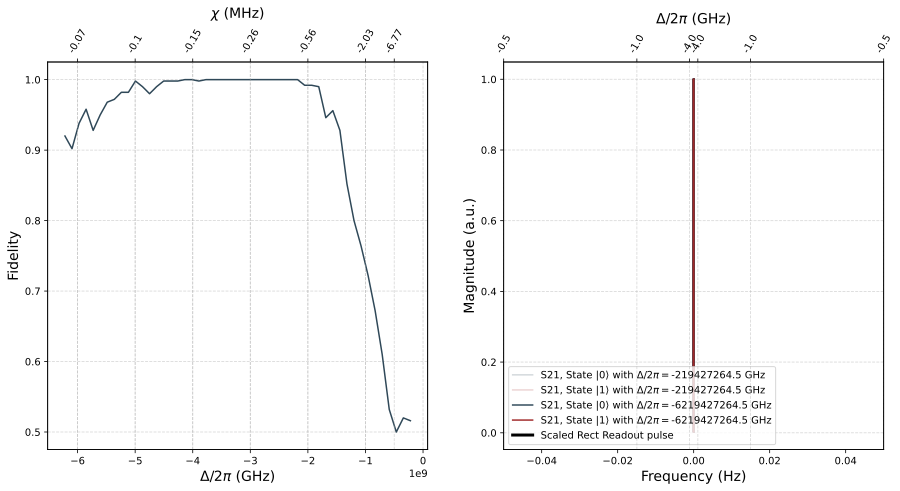

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

fig, axs_12 = plt.subplots(1, 2, figsize=(15, 7), dpi=300)

axs_12[0].set_xlabel(r'$\Delta/2\pi$ (GHz)')
axs_12[0].set_ylabel('Fidelity')

axs_12[0].plot(delta_arr, fidelity)

delta_for_plot = np.array([-6, -5, -4, -3, -2, -1, -0.5])
delta_for_plot1 = np.array([-4, -1, -0.5])
ax1 = axs_12[0].twiny()
ax1.set_xlim(axs_12[0].get_xlim())
ax1.set_xticks(delta_for_plot * 1e9)

ax1.set_xticklabels([round(x, 2) for x in chi(delta_for_plot) * 1000], rotation=60)
ax1.set_xlabel(r"$\chi$ (MHz)", labelpad=10)

# delta_indexes = [0, 30]
# delta_arr_some = delta_arr[::50]

f_pulse = 0
delta_arr_some = delta_arr


def plot_file(delta, iteration_n, state):
    shift = chi(delta) * 1e9 * (1 if state == 0 else -1)

    network = S2pUtils.create_resonator_S21(f_pulse + shift, Q, Q)

    frequencies_ghz = network.f
    s21_complex = network.s[:, 1, 0]

    # Assign colors directly (no colormap)
    if state == 0:
        base_color = 'C0'
    elif state == 1:
        base_color = 'C1'
    else:
        base_color = 'black'  # fallback in case of unexpected state

    # Transparency from 1.0 (first) to 0.6 (last)
    alpha = 0.2 + (iteration_n / (len(delta_arr_some) - 1)) * 0.8

    # Optional labeling for first/last
    label_text = None
    if iteration_n == len(delta_arr_some) - 1 or iteration_n == 0:
        label_text = (
                rf"S21, State $|{state}\rangle$"
                + r"$\text{ with } \Delta/2\pi=$"
                + str(round(delta_arr_some[iteration_n], 1)) + " GHz"
        )

    axs_12[1].plot(
        frequencies_ghz,
        np.abs(s21_complex),
        color=base_color,
        label=label_text,
        alpha=alpha
    )


# Loop over all deltas
for i, delta in tqdm(enumerate(delta_arr_some), total=len(delta_arr_some)):
    # path0 = os.path.join(simulation_path, f"{(delta)}_0.s2p")
    plot_file(delta, i, 0)

    # path1 = os.path.join(simulation_path, f"{delta}_1.s2p")
    plot_file(delta, i, 1)

pulse_length = 2 * 10 ** (-6)  # s

rect_readout_pulse = RectangularReadoutPulse(
    carrier_frequency=f_pulse,
    pulse_duration=pulse_length,
    pulse_power_dbm=-110,
    total_signal_time=2 * pulse_length,
    pulse_samples_number=pulse_samples_number,
)

# Add pulse overlay
t_signal = rect_readout_pulse.t_signal
dt = rect_readout_pulse.t_signal_times[1] - rect_readout_pulse.t_signal_times[0]
edges = (f_pulse * 0.99, f_pulse * 1.01)
f_signal, f_signal_frequencies = Pulse.to_frequency_domain(
    t_signal, dt, pulse_samples_number, edges, force_use_czt=True
)

axs_12[1].plot(
    f_signal_frequencies,
    4e11 * np.abs(f_signal),
    c='black',
    label="Scaled Rect Readout pulse",
    linewidth=3
)

axs_12[1].set_xlabel('Frequency (Hz)')
axs_12[1].set_ylabel('Magnitude (a.u.)')
axs_12[1].set_xlim(f_pulse * 0.999, f_pulse * 1.001)
axs_12[1].legend(loc='lower left')

ax2 = axs_12[1].twiny()
ax2.set_xlim(axs_12[1].get_xlim())
ax2.set_xticks(np.concatenate((-chi(delta_for_plot1), chi(delta_for_plot1))) * 1e9 + f_pulse)

ax2.set_xticklabels(np.concatenate((delta_for_plot1, delta_for_plot1)), rotation=60)
ax2.set_xlabel(r'$\Delta/2\pi$ (GHz)', labelpad=10)

axs_12[1].xaxis.grid(False, which='both')

# plt.tight_layout()
plt.savefig("s_params_exp_combined.pdf", bbox_inches='tight')
plt.show()

In [130]:
np.concatenate((chi(delta_for_plot1), chi(delta_for_plot1))) * 1e9 + f_pulse

array([ -148388.05256125, -2025293.26640445, -6773852.27889956,
        -148388.05256125, -2025293.26640445, -6773852.27889956])

In [131]:
from fidelity_analysis.utils import UnitConverter

power = -123  #dbm
kappa = 0.55 * 1e6 * 2 * np.pi
f_r = 6.065852884e9
UnitConverter().dbm_to_photons(power, f_r, kappa)

72.16714682936474

In [132]:
(6.0655 - 6.066) * 1e9 / 1e6

-0.4999999999997229

 /var/folders/4v/sw011n6n73n99lwpjk6j8klm0000gp/T/ipykernel_62418/2905775402.py: 28

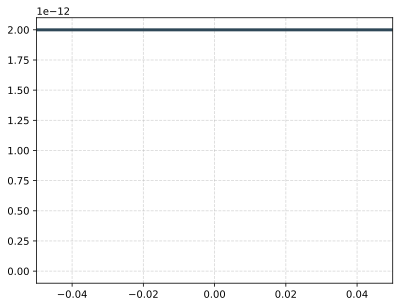

In [133]:
from fidelity_analysis.pulse import Pulse

pulse_samples_number = 2 ** 17

readout_pulse = rect_readout_pulse

plt.plot(readout_pulse.f_signal_frequencies,
         np.abs(readout_pulse.f_signal),
         c="C0",
         label=f"Rect Readout pulse: pulse_samples_number = 2^{np.log2(pulse_samples_number)}",
         linewidth=3
         )

t_signal = readout_pulse.t_signal
dt = readout_pulse.t_signal_times[1] - readout_pulse.t_signal_times[0]

edges = (f_pulse * 0.999, f_pulse * 1.001)
f_signal, f_signal_frequencies = Pulse.to_frequency_domain(t_signal, dt, pulse_samples_number,
                                                           edges, force_use_czt=True)
plt.plot(f_signal_frequencies,
         np.abs(f_signal),
         c="C2",
         label="Rect Readout pulse",
         linewidth=3,
         zorder=-10
         )

plt.xlim(edges)

plt.show()
